# Text classification and sentiment analysis: Twitter

Once text data has been converted into numerical features using the natural language processing techniques discussed in the previous sections, text classification works just like any other classification task.

In this notebook, we will apply these preprocessing technique to news articles, product reviews, and Twitter data and teach various classifiers to predict discrete news categories, review scores, and sentiment polarity.

## Imports

In [1]:
%matplotlib inline
import warnings
from collections import Counter, OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import pyarrow as pa   
import pyarrow.parquet as pq
from fastparquet import ParquetFile 
from scipy import sparse
from scipy.spatial.distance import pdist, squareform

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns

# spacy, textblob and nltk for language processing
from textblob import TextBlob, Word

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.externals import joblib

import lightgbm as lgb

import json
from time import clock, time

In [2]:
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

## Twitter Sentiment

We use a dataset that contains 1.6 million training and 350 test tweets from 2009 with algorithmically assigned binary positive and negative sentiment scores that are fairly evenly split.

Download the data from [here](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip).

Extract the content of the compressed file, move to 'data/sentiment140/' and rename the files:
- `training.1600000.processed.noemoticon.csv` to `train.csv`, and
- `testdata.manual.2009.06.14.csv` to `test.csv`

- 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive); training data has no neutral tweets
- 1 - the id of the tweet (2087)
- 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- 3 - the query (lyx). If there is no query, then this value is NO_QUERY. (only test data uses query)
- 4 - the user that tweeted (robotickilldozr)
- 5 - the text of the tweet (Lyx is cool)

### Read train/test data

We move the data to the faster parqu3et

In [ ]:
names = ['polarity', 'id', 'date', 'query', 'user', 'text']
train = (pd.read_csv('data/sentiment140/train.csv',
                     low_memory=False,
                     encoding='latin1',
                     header=None,
                     names=names,
                     parse_dates=['date'])
         .drop(['id', 'query'], axis=1)
         .drop_duplicates(subset=['polarity', 'text']))

train = train[train.text.str.len()<=140]
train.polarity = (train.polarity>0).astype(int)

In [ ]:
train.info(null_counts=True)

In [ ]:
train.to_parquet('data/sentiment140/train.parquet')

In [ ]:
test = (pd.read_csv('data/sentiment140/test.csv',
                    low_memory=False,
                    encoding='latin1',
                    header=None,
                    names=names,
                    parse_dates=['date'])
        .drop(['id', 'query'], axis=1)
        .drop_duplicates(subset=['polarity', 'text']))
test = test[(test.text.str.len()<=140) & (test.polarity.isin([0,4]))]

In [ ]:
test.info()

In [ ]:
test.to_parquet('data/sentiment140/test.parquet')

In [4]:
train = pd.read_parquet('data/sentiment140/train.parquet')
test = pd.read_parquet('data/sentiment140/test.parquet')

### Explore data

In [5]:
train.head()

,polarity,date,user,text
0,0,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
train.polarity = (train.polarity>0).astype(int)
train.polarity.value_counts()

1    784335
0    782333
Name: polarity, dtype: int64

In [7]:
test.polarity = (test.polarity>0).astype(int)
test.polarity.value_counts()

1    180
0    174
Name: polarity, dtype: int64

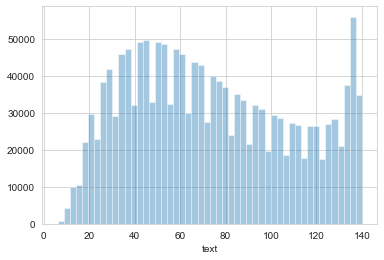

In [8]:
sns.distplot(train.text.str.len(), kde=False);

In [9]:
train.date.describe()

count                 1566668
unique                 765666
top       2009-06-15 12:53:14
freq                       20
first     2009-04-06 22:19:45
last      2009-06-25 10:28:31
Name: date, dtype: object

In [10]:
train.user.nunique()

650606

In [11]:
train.user.value_counts().head(10)

lost_dog           549
webwoke            341
SallytheShizzle    276
VioletsCRUK        275
mcraddictal        274
tsarnick           247
what_bugs_u        246
Karen230683        237
DarkPiano          232
SongoftheOss       226
Name: user, dtype: int64

### Create text vectorizer

We create a document-term matrix with 934 tokens as follows:

In [12]:
vectorizer = CountVectorizer(min_df=.001, max_df=.8, stop_words='english')
train_dtm = vectorizer.fit_transform(train.text)

In [13]:
train_dtm

<1566668x934 sparse matrix of type '<class 'numpy.int64'>'
	with 6332930 stored elements in Compressed Sparse Row format>

In [14]:
test_dtm = vectorizer.transform(test.text)

### Train Naive Bayes Classifier

In [15]:
nb = MultinomialNB()
nb.fit(train_dtm, train.polarity)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Predict Test Polarity

In [16]:
predicted_polarity = nb.predict(test_dtm)

### Evaluate Results

In [17]:
accuracy_score(test.polarity, predicted_polarity)

0.7768361581920904

### TextBlob for Sentiment Analysis

In [18]:
sample_positive = train.text.loc[256332]
print(sample_positive)
parsed_positive = TextBlob(sample_positive)
parsed_positive.polarity

Ok its cake and ice cream time! Ha! See what I'm talking about! The temptation is there! 


1.0

In [19]:
sample_negative = train.text.loc[636079]
print(sample_negative)
parsed_negative = TextBlob(sample_negative)
parsed_negative.polarity

 i hate this place


-0.8

In [20]:
def estimate_polarity(text):
    return TextBlob(text).sentiment.polarity

In [21]:
train[['text']].sample(10).assign(sentiment=lambda x: x.text.apply(estimate_polarity)).sort_values('sentiment')

,text,sentiment
29306,Shouldn't still be awake. Feeling horrible. No...,-0.675000
773458,sigh.. Im so tired n my head is pounding n I c...,-0.400000
1381622,time to charge my mind and body...Holiday seas...,0.000000
782378,@donniemacfad I think it is. The news said it'...,0.000000
764291,Washing dishes again!,0.000000
209779,@Lyric07 @sassy0315 r we still on for ladies n...,0.000000
554788,@thekeithchegwin why do you keep speeding up??,0.000000
642257,"@JonathanRKnight Oh yeah, I also found out you...",0.016667
1113926,@treadoninfinity i didn't want to say q-u-a-k-...,0.458333
807168,@divadoll123 they don't really think he's bril...,0.533333


### Compare with TextBlob Polarity Score

We also obtain TextBlob sentiment scores for the tweets and note (see left panel in below figure) that positive test tweets receive a significantly higher sentiment estimate. We then use the MultinomialNB ‘s model .predict_proba() method to compute predicted probabilities and compare both models using the respective Area Under the Curve (see right panel below).

In [22]:
test['sentiment'] = test.text.apply(estimate_polarity)

In [23]:
accuracy_score(test.polarity, (test.sentiment>0).astype(int))

0.7429378531073446

#### ROC AUC Scores

In [24]:
roc_auc_score(y_true=test.polarity, y_score=test.sentiment)

0.8254948914431672

In [25]:
roc_auc_score(y_true=test.polarity, y_score=nb.predict_proba(test_dtm)[:, 1])

0.848595146871009

In [26]:
fpr_tb, tpr_tb, _ = roc_curve(y_true=test.polarity, y_score=test.sentiment)
roc_tb = pd.Series(tpr_tb, index=fpr_tb)
fpr_nb, tpr_nb, _ = roc_curve(y_true=test.polarity, y_score=nb.predict_proba(test_dtm)[:, 1])
roc_nb = pd.Series(tpr_nb, index=fpr_nb)

The Naive Bayes model outperforms TextBlob in this case.

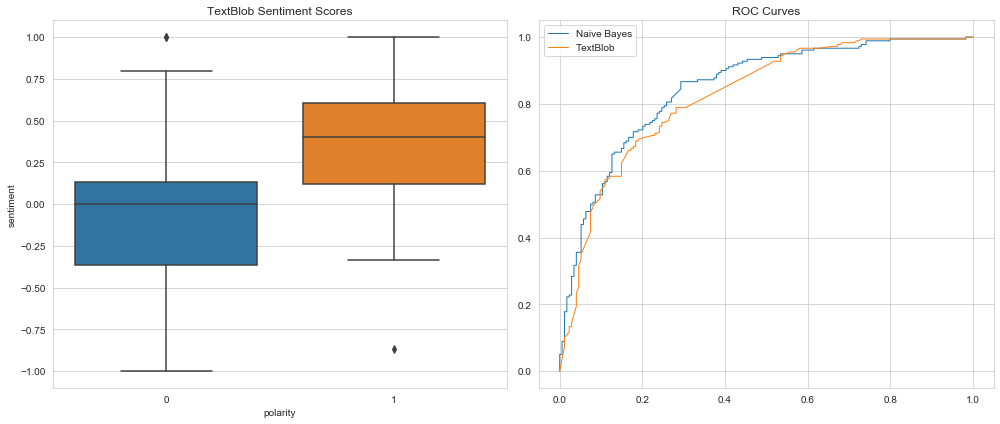

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.boxplot(x='polarity', y='sentiment', data=test, ax=axes[0])
axes[0].set_title('TextBlob Sentiment Scores')
roc_nb.plot(ax=axes[1], label='Naive Bayes', legend=True, lw=1, title='ROC Curves')
roc_tb.plot(ax=axes[1], label='TextBlob', legend=True, lw=1)
fig.tight_layout()
fig.savefig('figures/twitter_sentiments', dpi=300);